#Load Library

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import cv2 as cv
import os
from google.colab import drive
import matplotlib.pyplot as plt
from itertools import combinations
import shutil

In [ ]:
# z = cv2.imread("set3.png")
# cv2_imshow(z)

In [ ]:

if not(os.path.exists('/content/mask/')):
  os.mkdir("/content/mask")
  drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# from google.colab import drive
# drive.flush_and_unmount()

In [ ]:
def permute_threshold(file_name,obj_num):
  """
    apply diffrent threshold to detect combination.
  """
  for i in range(0,500,25):
        img = cv.imread(file_name)

        img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img_contours = img.copy()


        thresh = i
        ret,thresh_img = cv.threshold(img_gray, thresh, 255, cv.THRESH_BINARY)
        contours, _ = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
        contours=sorted(contours, key = cv.contourArea, reverse = True)[:obj_num]

        cv.drawContours(img_contours, contours, -1, (0,255,0), 10)
        print(i)
        cv2_imshow(img_contours)

In [ ]:
def countours_card(file_name,obj_num,write_path="",thershold=250):
    """
    write individual cards images to write path
    """
    img = cv.imread(file_name)

    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_contours = img.copy()
    thresh = thershold
    ret,thresh_img = cv.threshold(img_gray, thresh, 255, cv.THRESH_BINARY)
    contours, _ = cv.findContours(thresh_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours=sorted(contours, key = cv.contourArea, reverse = True)[:obj_num]
    cv.drawContours(img_contours, contours, -1, (0,255,0), 10)
    cv2_imshow(img_contours)
    for (i,c) in enumerate(contours):
        x,y,w,h= cv.boundingRect(c)
        cropped_contour = img[y:y+h, x:x+w]
        cropped_contour = cv.resize(cropped_contour,(720,720))
        cv.imwrite( f"{write_path}{file_name[:-4]}_"+str(i) + ".jpg", cropped_contour)


In [ ]:
# permute_threshold('set3.png',12)

In [ ]:
# countours_card('set3.png',12,"/content/mask/",thershold=250)

In [ ]:
import numpy as np
def hsv_rgb(image_name):
  """
    read image file return image in HSV and RGB
  """
  img = cv2.medianBlur(cv2.imread(image_name),5)
  img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return img_hsv,img_rgb

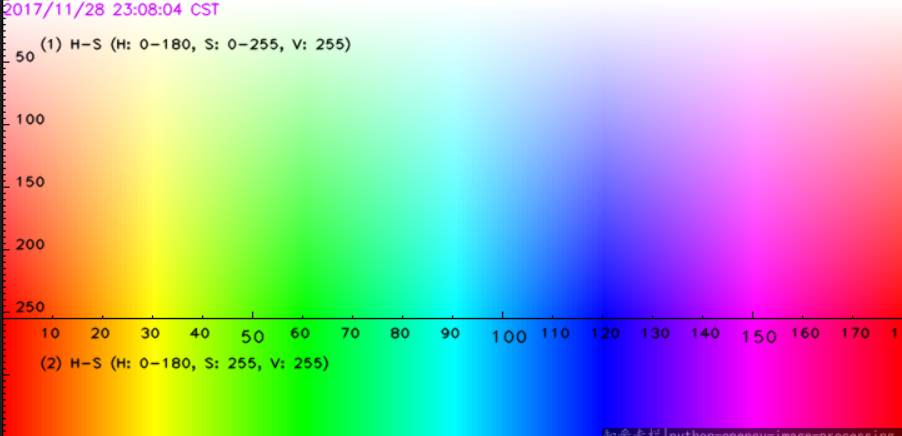

In [ ]:
def max_mask(img_hsv,verbose=False):
  """
    Input is HSV image return mask of maximum channel
  """
  color_map = {"green":[np.array([50, 20, 20]),np.array([100, 255, 255])	],"red":[np.array([160,20,70]),np.array([190,255,255])],"blue":[np.array([121,20,20]), np.array([154,255,255])	] }
  maps = []
  for i in color_map.values():
    lower_bound ,upper_bound = i
    maps.append(cv2.inRange(img_hsv, lower_bound, upper_bound))
  max_channel = np.argmax((np.max(maps[0]),np.max(maps[1]),np.max(maps[2])))
  mask = maps[max_channel]
  if verbose:
    print(f"color is ",list(color_map.keys())[max_channel])
  return mask



In [ ]:
def color_mask(img_hsv,verbose=False):
  """
  Input HSV image return value of color
  """
  color_map = {"green":[np.array([50, 20, 20]),np.array([100, 255, 255])	],"red":[np.array([160,20,70]),np.array([190,255,255])],"blue":[np.array([121,20,20]), np.array([154,255,255])	] }
  maps = []
  for i in color_map.values():
    lower_bound ,upper_bound = i
    maps.append(cv2.inRange(img_hsv, lower_bound, upper_bound))
  max_channel = np.argmax([np.max(maps[0]),np.max(maps[1]),np.max(maps[2])])
  # print(color_map.keys(),max_channel)
  mask = maps[max_channel]
  return max_channel



In [ ]:
# countours_card('set1.png',12,'/content/mask/',thershold=250)

In [ ]:
shade_dic = {"2":'blank',"0":'solid',"1":'shaded'}
shape_dic = {"0":'diamond',"1":"squiggle","2":'circle'}

In [ ]:
"""
  Global threshold for match cut-off
"""
global_threshold_shade=0.7

In [ ]:
def is_match(cnt1,cnt2,verbose=False):
    """
      Take two mask return similarity
    """
    result = cv2.matchTemplate(cnt1, cnt2, cv2.TM_CCOEFF_NORMED)
    similarity_score = result.max()
    if verbose:
      print("Matching Image 1 with Image 2:", similarity_score)
    return similarity_score

In [ ]:
def matching(file1,file2,threshold=0,verbose=False):
  """
    Input two image return similarity if less the threshold
  """
  img_name1 = file1
  back_match_hsv,match_rbg = hsv_rgb(img_name1 )
  back_match_mask = max_mask(back_match_hsv,False)

  x1, y1, w1, h1 = cv.boundingRect(back_match_mask)
  img_name2 = file2
  fore_match_hsv,fore_match_rbg = hsv_rgb(img_name2 )
  fore_match_mask = max_mask(fore_match_hsv,False)
  x2, y2, w2, h2 = cv.boundingRect(fore_match_mask)

  x=min(x1,x2)
  y=min(y1,y2)
  w=max(w1,w2)
  h=max(h1,h2)

  fore_match_mask = fore_match_mask[y:y+h, x:x+w]
  back_match_mask = back_match_mask[y:y+h, x:x+w]
  val = is_match(back_match_mask,fore_match_mask)

  if val>threshold and verbose:
    plt.imshow(np.hstack((back_match_mask,fore_match_mask)))
    plt.show()
  return val

In [ ]:
from glob import glob
def shape_shade_id(filename,threshold=global_threshold_shade):
  """
  Input filename with path return shape shade
  """
  shapes = ['circle','diamond','squiggle']
  shape_map = []
  imgs =None
  for i in shapes:
    path="/content/drive/MyDrive/Mask/"+i
    val = 1e308
    shape_map.append(0)
    for j in os.listdir(path):
      n1 = path+"/"+j
      if matching(filename,n1,threshold) >threshold:
        shape_map[-1]+=1
        imgs = j
  return imgs.split("_")[0],imgs.split("_")[1]



In [ ]:
# matching("/content/mask/set1_5.jpg","/content/drive/MyDrive/Mask/diamond/0_0_0_1.jpg")

In [ ]:
def counting(filename):
  """
    Input filename with path return number of shape
  """
  back_match_hsv,match_rbg = hsv_rgb(filename )
  back_match_mask = max_mask(back_match_hsv,False)
  _, _, w1, _ = cv.boundingRect(back_match_mask)
  if w1<200:
    return 0

  elif w1<400:
    return 1

  else:
    return 2


In [ ]:
def single_id(filename,mapping_idc):
  """
  Input filename with path return shape,shade,color,number
  """

  shape,shade = shape_shade_id(filename)
  back_match_hsv,match_rbg = hsv_rgb(filename )
  number = counting(filename)
  color = color_mask(back_match_hsv)
  mapping_idc['_'.join([shape,shade,str(color),str(number)])] = filename
  return shape,shade,str(color),str(number)

In [ ]:

def attributeAllSameOrAllDifferent(attribute):
  """
  matching diffrent and similarity of colour shape number and shade (Attribute) finding to find score
  """
  return len(attribute) == 3 or len(attribute) == 1


def rule(list1):
  """
    Input Attribute return correct combination
  """
  l=[]
  for card_a, card_b, card_c in combinations(list1, 3):
      shape1,shade1,colour1,number1= card_a
      shape2,shade2,colour2,number2= card_b
      shape3,shade3,colour3,number3= card_c

      colors = {colour1, colour2, colour3}
      shapes = {shape1, shape2, shape3}
      shades = {shade1, shade2, shade3}
      numbers = {number1, number2, number3}
      if (attributeAllSameOrAllDifferent(colors) and attributeAllSameOrAllDifferent(shapes) and attributeAllSameOrAllDifferent(shades) and attributeAllSameOrAllDifferent(numbers)):
        card1 = "_".join(card_a)
        card2 = "_".join(card_b)
        card3 = "_".join(card_c)
        l2=[card1,card2,card3]
        l.append(l2)
  return l

In [ ]:
def gameplay(filename,write_addr="/content/inf/"):
  """
    Input file set of combined image  print all combination
  """
  mapping_idc = {}
  try:
    os.mkdir(write_addr)

    countours_card(filename,12,write_addr,thershold=250)
    info =[]
    for i in os.listdir(write_addr):
      info.append(single_id(write_addr+i,mapping_idc))
    for count,i in enumerate(rule(info)):
      a,b,c = i
      plt.imshow(np.hstack((cv2.cvtColor(cv.imread(mapping_idc[a]), cv2.COLOR_BGR2RGB),cv2.cvtColor(cv.imread(mapping_idc[b]), cv2.COLOR_BGR2RGB),cv2.cvtColor(cv.imread(mapping_idc[c]), cv2.COLOR_BGR2RGB))))
      plt.title(f"Combination {count+1}")
      plt.axis('off')
      plt.show()
  finally:
    shutil.rmtree("/content/inf/")



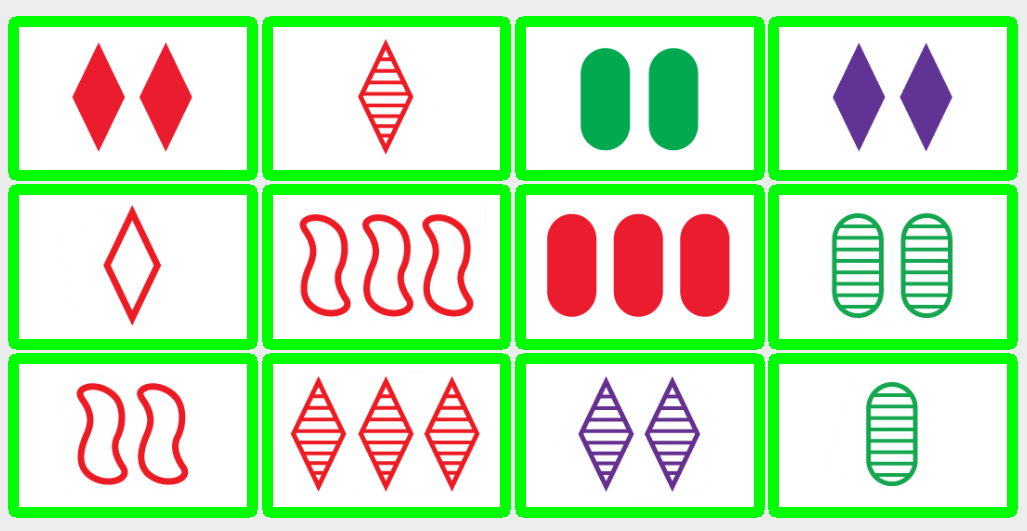

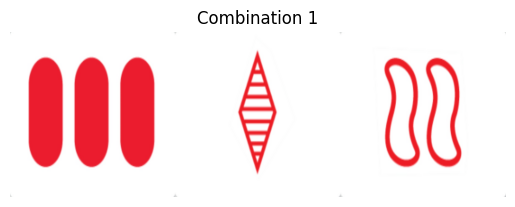

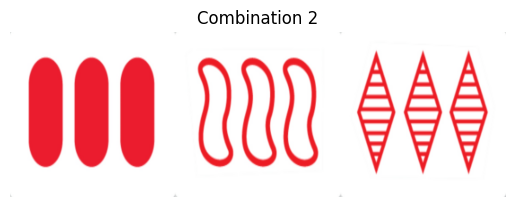

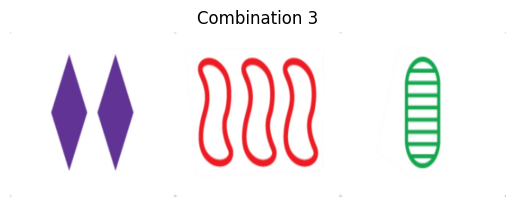

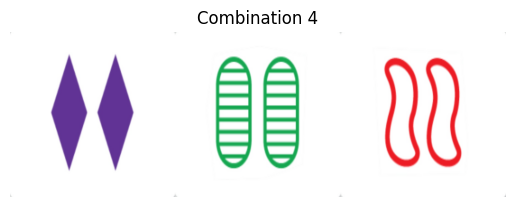

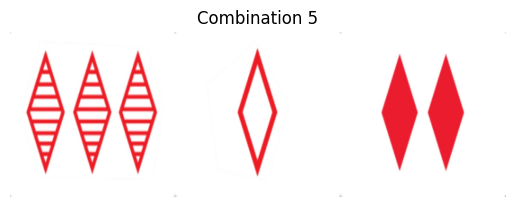

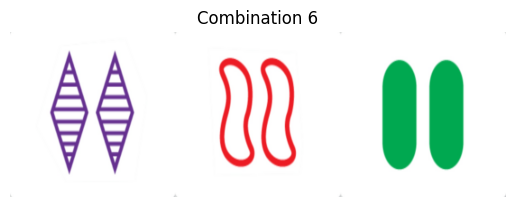

time taken to run: 34.229849005999995


In [ ]:
import time
t1 = time.perf_counter()

set_file = 'set11.png'
gameplay(set_file)

t2 = time.perf_counter()
print('time taken to run:',t2-t1)